<h1>🤖 MLAI Workshop #03</h1>

In the first workshop we explored the trade-offs between the hypothesis space, dataset, optimization and how it influenced the final solution using simple hand-crafted models

IMAGE OF HYPOTHESIS SPACE

In the second workshop we put this into context and explored how we can design universal function approximators, and explore some of the challenges and limitations in learning from data

IMAGE OF FUNCTION LEARNING

In [105]:
import torch

# observe some data using a noisy observation process
def observe_noisy(f, x):
  # Input noise ~ N(mean=0.05, std=0.02)
  x_noise = torch.randn_like(x) * 0.02 + 0.05
  x_measure = x + x_noise

   # Evaluate the (noisy) inputs
  y_pred = f(x_measure)

  # Output noise ~ N(mean=-0.05, std=0.08)
  y_noise = torch.randn_like(y_pred) * 0.08 - 0.05
  y_obs = y_pred + y_noise

  return y_obs

<h2>Section 1. Prior Section on Limitations</h2>



<h3>Section 1A. Summary of Workshop #2</h3>

First, let's define a dataset that holds our observations of the data generation process.

In [106]:
from typing import Callable

# create a dataset
class Dataset:
  def __init__(self, f: Callable, a: float, b: float, N: int = 100):
    super(Dataset, self).__init__()

    # Sample x uniformly in [a, b], shape [N,1]
    self.x = torch.rand(N, 1) * (b - a) + a

    # Observe f(x) through noise process, also [N,1]
    self.y = observe_noisy(f, self.x)

Let's define a specific function representing the data generating process:

\begin{align*}
  f^{*}(x) = e^{-x^{2}} sin(5.8\pi x + 0.41) \tag{1.1}
\end{align*}

And create a dataset using this function on the domain $x \in \left[0, 1\right]$


Text(0, 0.5, 'y_obs')

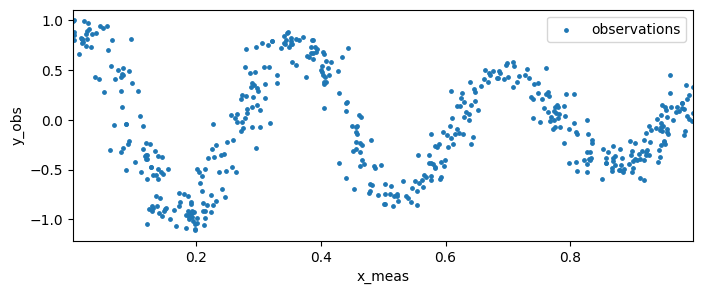

In [107]:
import matplotlib.pyplot as plt

# define a target function i.e. your data generating process
f = lambda x: torch.exp(-x**2) * torch.sin(5.8 * torch.pi * x + 0.41)

# define a dataset with your function
dataset = Dataset(f, 0, 1, 500)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

We assume we do not have access to the structure of $f^{*}$ and instead opt to build a flexible hypothesis space capable of learning to approximate other functions. We will use a multilayer perceptron with ReLU non-linear activation to enable our model to build abstract piecewise-affine approximations of arbitrary functions.

In [108]:
import torch.nn as nn

# define a layer of perceptrons as a building block
class PerceptronLayer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, act: bool = True):
        super(PerceptronLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.act = nn.ReLU() if act else nn.Identity()

    def forward(self, x):
        x = self.act(self.fc(x))
        return x

# create a flexible hypothesis space using an MLP
class MultiLayerPerceptron(nn.Module):
    def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1, input_dim: int = 1, output_dim: int = 1):
        super(MultiLayerPerceptron, self).__init__()
        modules = [PerceptronLayer(1, hidden_dim)] # input layer
        for _ in range(hidden_layers): modules.append(PerceptronLayer(hidden_dim, hidden_dim)) # hidden layers
        modules.append(PerceptronLayer(hidden_dim, 1, act=False)) # output layer (no activation)
        self.layers = nn.ModuleList(modules) # store layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Let's define some helper functions to simplify the process of training this model.

In [109]:
from tqdm import tqdm

# define a training loop
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(dataset.y, y_pred)
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

In [110]:
# define some functions for plotting our results
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

def plot_predictions(model, dataset, ax = None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return ax

Finally, lets train our model using these building blocks.

In [111]:
# train a model
dataset = Dataset(f, a=0, b=1, N=500) # create 500 samples (x,f(x)), where x in range [a,b]
model = MultiLayerPerceptron(hidden_layers=2, hidden_dim=30) # 2 hidden layers / 30 perceptrons per layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500) # train model for 500 steps

loss: 0.036: 100%|██████████| 500/500 [00:02<00:00, 242.23it/s]


We can explore how the different aspects of the machine learning problem: the hypothesis space $\mathcal{H}$ (MLP), the dataset $\mathcal{D}$ (observations), the optimizer $\mathcal{O}$ (Adam), and the the loss function $\mathcal{L}$ (MSE) impact the performance of the final model we obtain $\hat{f}$.

We can see that if our hypothesis space is too small we struggle to fit the dataset.

We can see that our dataset constrains how we learn.

And we can see that as out solution space becomes larger the optimizer often needs to be more robust at navigating the loss landscape.

<Axes: >

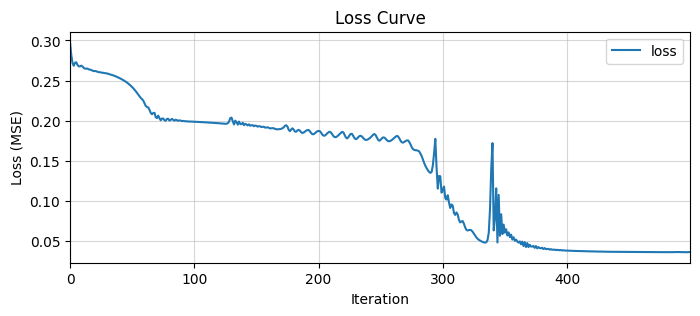

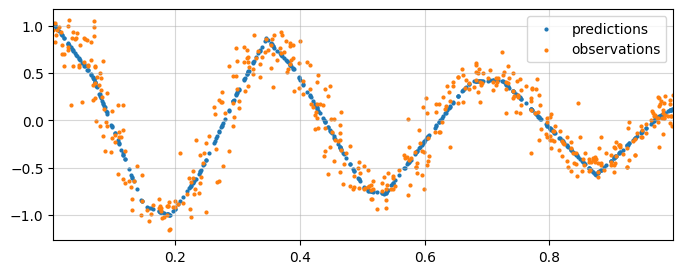

In [112]:
plot_loss_curve(losses)
plot_predictions(model, dataset)

<h3>Section 1B. How robust is our model?</h3>

We can evaluate how well this class of model interpolates and extrapolates across the data manifold to understand their generalization capabilities.

loss: 0.061: 100%|██████████| 500/500 [00:02<00:00, 230.80it/s]


(0.0, 1.0)

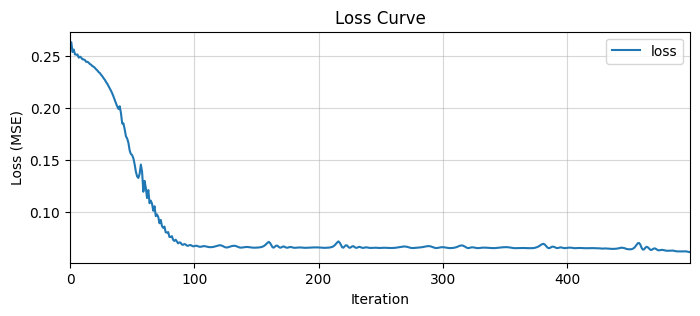

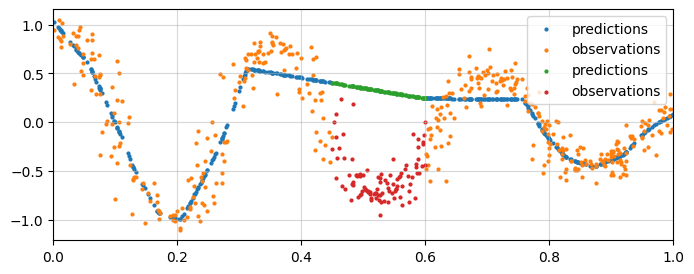

In [115]:
# define your domain
dataset = Dataset(f, a=0, b=1, N=500)

# lets explore how well it interpolates by erasing a region
x_min, x_max = 0.45, 0.60
keep_idxs = (dataset.x < x_min) | (dataset.x > x_max)
dataset.x = dataset.x[keep_idxs].unsqueeze(-1)
dataset.y = dataset.y[keep_idxs].unsqueeze(-1)

# train a model
model = MultiLayerPerceptron(hidden_layers=2, hidden_dim=30) # 0 hidden layers / 1 perceptrons
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

# plot the results
plot_loss_curve(losses)
ax = plot_predictions(model, dataset)

# see how well it interpolates
dataset_interp = Dataset(f, a=x_min, b=x_max, N=100)
ax = plot_predictions(model, dataset_interp, ax)
ax.set_xlim(0, 1)

(-1.0, 2.0)

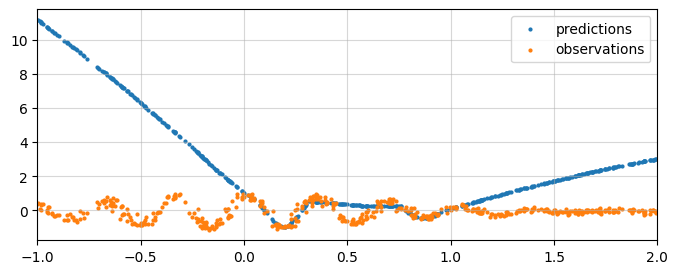

In [116]:
# define a much broader domain to see how well it extrapolates
dataset_extrap = Dataset(f, -1, 2, 500)

# plot the results
ax = plot_predictions(model, dataset_extrap)
ax.set_xlim(-1, 2)

<h3>Section 1C. Investigating the Model</h3>

We can investigate what these models are doing under the hood by exploring the activation across different neurons.

In [117]:
# lets explore the model
model

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): PerceptronLayer(
      (fc): Linear(in_features=1, out_features=30, bias=True)
      (act): ReLU()
    )
    (1-2): 2 x PerceptronLayer(
      (fc): Linear(in_features=30, out_features=30, bias=True)
      (act): ReLU()
    )
    (3): PerceptronLayer(
      (fc): Linear(in_features=30, out_features=1, bias=True)
      (act): Identity()
    )
  )
)

We can explore how a given Perceptron in the network activates.

In [118]:
# store
activations = {}

# define a forward pass hook to grab the outputs
def make_hook(name):
  def hook(module, input, output):
    # detach to avoid keeping the full graph
    activations[name] = output.detach().cpu()
  return hook

# register model hooks to the ReLU outputs
for idx, layer in enumerate(model.layers):
  if not layer.act._forward_hooks:
    layer.act.register_forward_hook(make_hook(f"layer_{idx}_relu"))

# run a forward pass on region to populate activations
x = torch.linspace(-1, 2, steps=1000).unsqueeze(-1)
_ = model(x)

(-1.0, 2.0)

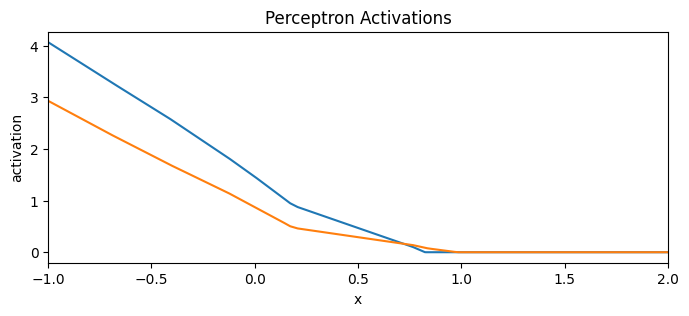

In [126]:
# which perceptron to inspect
layer_index = 1
perceptron_indexes = [0, 1]

# acts is of shape [N, output_dim]
fig, ax = plt.subplots(figsize=(8,3))
for perceptron_index in perceptron_indexes:
  ax.plot(x, activations[f"layer_{layer_index}_relu"][:,perceptron_index], label=f"layer_{layer_index}_relu:{perceptron_index}")
ax.set_title(f"Perceptron Activations")
ax.set_xlabel("x")
ax.set_ylabel("activation")
ax.set_xlim(x.min(), x.max())

In [127]:
# explore the weights across different layers
layer_index = 2
perceptron_index = 4

#
layer = model.layers[layer_index]
weights = layer.fc.weight[perceptron_index].detach().cpu()
bias = layer.fc.bias[perceptron_index].detach().cpu()
print(f"W {weights.shape} = {weights}")
print(f"b {bias.shape} = {bias}")

W torch.Size([30]) = tensor([-0.0690, -0.0108, -0.0572,  0.0786,  0.0170,  0.0758, -0.0980, -0.1576,
         0.1641, -0.1278,  0.1008, -0.1160, -0.0371,  0.1139,  0.1340, -0.1286,
         0.0762,  0.0492,  0.0245, -0.1552, -0.0562, -0.0985, -0.1208,  0.1787,
         0.1092, -0.1268,  0.1427,  0.0084, -0.0395,  0.1554])
b torch.Size([]) = 0.002368591260164976


Visually inspecting the weights and biases of these networks becomes increasingly difficult to interpret, but we can see the network is learning increasingly more complex and abstract piecewise-affine approximations.

Polynomial error interpolation, bounded by how much the data resolves the change

<h2>Section 2. Lets Explore a more Complex example</h2>

We've been simply attempting to learn a function, while this is useful, we've been working off the assumption we have a function. Let's explore a slightly more abstract concept

The spiral problem cannot be solved by a linear classifier in input space. The classes are separated by a nonlinear curve (spirals), so a model must learn to fit a complex boundary.

Thus, we can't draw a single straight line to separate the data. We need a boundary that bends, loops, and wraps around the origin — this is what we mean by curve fitting in this context.



In [224]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral(N=100, noise=0.2):
    """
    Generates a 2D spiral dataset with two arms (binary classification).
    Returns:
        x: Tensor of shape [2N, 2]
        y: Tensor of shape [2N] with labels 0 or 1
    """
    theta = np.sqrt(np.random.rand(N)) * 2 * np.pi  # angle
    r_a = 2 * theta + np.pi
    r_b = -2 * theta - np.pi

    # Spiral A (label 0)
    x_a = np.stack([np.cos(theta) * r_a, np.sin(theta) * r_a], axis=1)
    x_a += np.random.randn(N, 2) * noise
    y_a = np.zeros(N)

    # Spiral B (label 1)
    x_b = np.stack([np.cos(theta) * r_b, np.sin(theta) * r_b], axis=1)
    x_b += np.random.randn(N, 2) * noise
    y_b = np.ones(N)

    x = np.concatenate([x_a, x_b], axis=0)
    y = np.concatenate([y_a, y_b], axis=0)

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # for BCE loss

    return x, y


In [225]:
import torch.nn as nn

class SpiralClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Single logit output
        )

    def forward(self, x):
        return self.net(x)


In [226]:
x, y = generate_spiral(N=500)

model = SpiralClassifier(input_dim=2, hidden_dim=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

# Training loop
for step in range(3000):
    logits = model(x)
    loss = loss_fn(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")


Step 0, Loss: 0.6435
Step 500, Loss: 0.4157
Step 1000, Loss: 0.1103
Step 1500, Loss: 0.0358
Step 2000, Loss: 0.0196
Step 2500, Loss: 0.0136


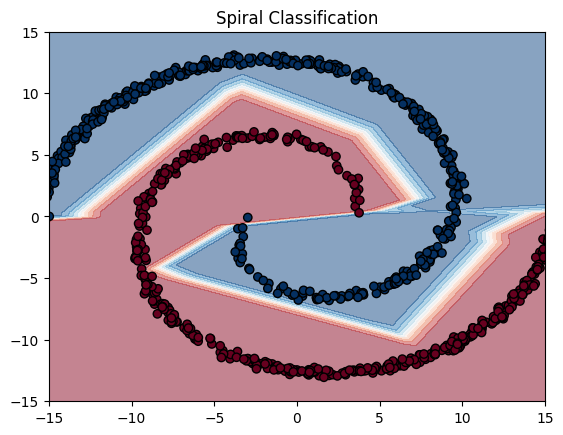

In [227]:
# Predict and plot
xx, yy = torch.meshgrid(torch.linspace(-15, 15, 1000), torch.linspace(-15, 15, 1000), indexing='ij')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
with torch.no_grad():
    probs = torch.sigmoid(model(grid)).reshape(xx.shape)

plt.contourf(xx.numpy(), yy.numpy(), probs.numpy(), levels=10, cmap='RdBu', alpha=0.50)
plt.scatter(x[:, 0], x[:, 1], c=y.squeeze(), cmap='RdBu', edgecolor='k')
plt.title("Spiral Classification")
plt.xlim(-15,15)
plt.show()


Lets remind ourselves what each Perceptron unit does

At its core, a neuron in a linear layer computes:

Then:

In the first layer, this acts as a linear classifier or detector — slicing input space with a hyperplane.

After a nonlinearity (e.g., ReLU), it activates only for one side of the hyperplane.

In deeper layers, neurons respond to combinations of previous activations, not raw input.



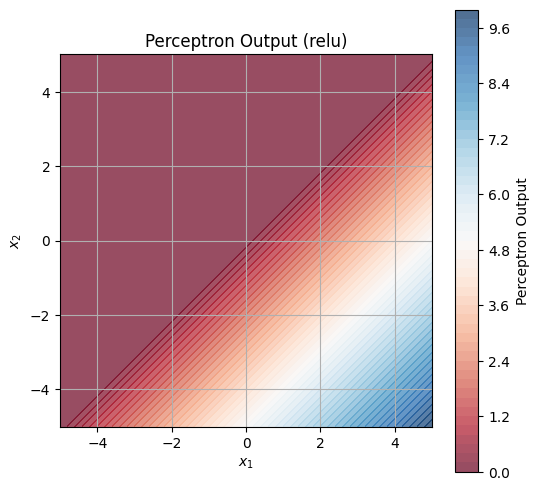

In [251]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_perceptron_2d(w, b, activation='none', bounds=5, resolution=300):
    """
    Visualize the output of a single perceptron with 2D input.

    Args:
        w: torch.tensor of shape (2,) — weights
        b: float — bias
        activation: 'none', 'relu', or 'sigmoid'
        bounds: float — plot limits for x and y
        resolution: int — grid resolution
    """
    assert w.shape == (2,), "Weights must be for 2D input"

    # Create input grid
    xx, yy = torch.meshgrid(
        torch.linspace(-bounds, bounds, resolution),
        torch.linspace(-bounds, bounds, resolution),
        indexing='ij'
    )
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # [res², 2]

    # Compute perceptron output: z = w^T x + b
    z = grid @ w + b

    if activation == 'relu':
        z = torch.relu(z)
    elif activation == 'sigmoid':
        z = torch.sigmoid(z)

    zz = z.reshape(xx.shape).detach().numpy()

    # Plot heatmap
    plt.figure(figsize=(6, 6))
    plt.contourf(xx.numpy(), yy.numpy(), zz, levels=50, cmap='RdBu', alpha=0.7)
    plt.colorbar(label='Perceptron Output')
    plt.title(f'Perceptron Output ({activation})')

    # Plot decision boundary (z = 0)
    if activation == 'none':
        a, b_ = w
        c = -b
        if b_ != 0:
            y_line = lambda x: -(a / b_) * x - (b / b_)
            x_vals = np.linspace(-bounds, bounds, 500)
            y_vals = y_line(x_vals)
            plt.plot(x_vals, y_vals, 'k--', label='z(x) = 0')
            plt.legend()

    plt.xlim(-bounds, bounds)
    plt.ylim(-bounds, bounds)
    plt.gca().set_aspect('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.show()

w = torch.tensor([1.0, -1.0])  # weight vector
b = 0.0                        # bias

# visualize_perceptron_2d(w, b, activation='none')     # Linear output
visualize_perceptron_2d(w, b, activation='relu')     # After ReLU
# visualize_perceptron_2d(w, b, activation='sigmoid')  # Sigmoid response


In [250]:
import torch
import plotly.graph_objects as go
import numpy as np

def interactive_perceptron_3d_plot(w, b, activation='none', bounds=5, resolution=200):
    """
    Interactive 3D surface plot for a 2D perceptron using Plotly.

    Args:
        w (torch.Tensor): weights of shape [2]
        b (float): bias term
        activation (str): 'none', 'relu', or 'sigmoid'
        bounds (float): range of input axes
        resolution (int): resolution of the grid
    """
    assert w.shape == (2,), "Weights must be 2D for this visualization"

    # Create grid
    x = torch.linspace(-bounds, bounds, resolution)
    y = torch.linspace(-bounds, bounds, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    # Compute perceptron output
    z = grid @ w + b
    if activation == 'relu':
        z = torch.relu(z)
    elif activation == 'sigmoid':
        z = torch.sigmoid(z)

    zz = z.reshape(xx.shape).cpu().numpy()

    # Create interactive 3D surface plot
    fig = go.Figure(data=[
        go.Surface(
            z=zz,
            x=xx.numpy(),
            y=yy.numpy(),
            colorscale='Viridis',
            showscale=True
        )
    ])

    fig.update_layout(
        title=f'Interactive Perceptron Surface ({activation})',
        scene=dict(
            xaxis_title='x₁',
            yaxis_title='x₂',
            zaxis_title='output',
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


w = torch.tensor([1.0, 1.0])
b = 0.0

# interactive_perceptron_3d_plot(w, b, activation='none')
interactive_perceptron_3d_plot(w, b, activation='relu')
# interactive_perceptron_3d_plot(w, b, activation='sigmoid')


Each linear layer (like Linear(2, 10)) projects the input into a new space:

ℎ
=
ReLU
(
𝑊
𝑥
+
𝑏
)
h=ReLU(Wx+b)
The matrix W rotates, scales, and projects the 2D input into a higher-dimensional space.

Each neuron in the layer defines a hyperplane — this is analogous to projecting the data onto different axes.

This step untangles the twisted spiral by reshaping it in a higher-dimensional feature space.

Think of this like flattening a crumpled piece of paper into 3D so it's easier to separate.



After the projection, the nonlinear activation (like ReLU) folds the space by clamping negative values to zero:

This breaks symmetry and introduces bends in the feature space

ReLU introduces nonlinear partitions that bend across the input space

These folds let the network represent curved and nested boundaries

Think of ReLU as creating creases — like origami — that fold flat features into complex shapes.

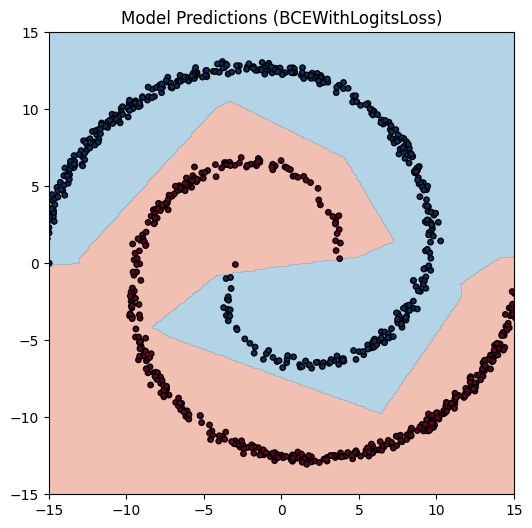

In [228]:
import matplotlib.pyplot as plt
import torch

def plot_binary_model_predictions(model, x, y, bounds=15, resolution=300):
    model.eval()

    # Create grid
    xx, yy = torch.meshgrid(
        torch.linspace(-bounds, bounds, resolution),
        torch.linspace(-bounds, bounds, resolution),
        indexing='ij'
    )
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    # Get model output on grid
    with torch.no_grad():
        logits = model(grid).squeeze()         # shape: [res²]
        probs = torch.sigmoid(logits)          # [res²]
        preds_grid = (probs >= 0.5).float()

        # Predict on actual data points too
        preds_data = (torch.sigmoid(model(x)) >= 0.5).squeeze()

    zz = preds_grid.reshape(xx.shape).numpy()

    # Plot decision regions
    plt.figure(figsize=(6, 6))
    plt.contourf(xx.numpy(), yy.numpy(), zz, levels=1, cmap='RdBu', alpha=0.5)

    # Plot original data colored by model predictions
    plt.scatter(x[:, 0], x[:, 1], c=preds_data.numpy(), cmap='RdBu', edgecolor='k', s=15)
    plt.title("Model Predictions (BCEWithLogitsLoss)")
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.show()


plot_binary_model_predictions(model, x, y)

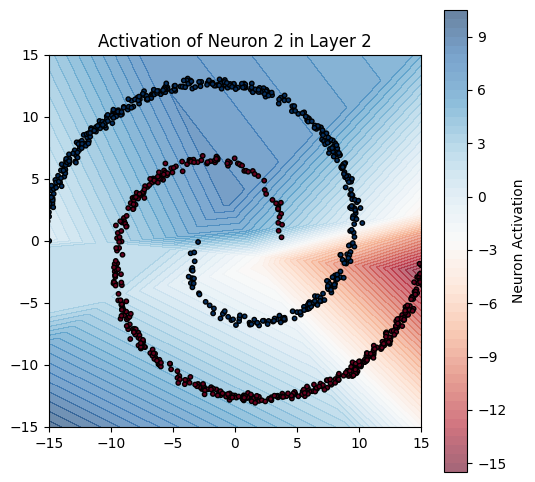

In [239]:
def plot_layer_neuron_response(model, x, y, layer_idx=0, neuron_idx=0, bounds=15, resolution=1000):
    import numpy as np
    import matplotlib.pyplot as plt

    assert isinstance(model.net[layer_idx], nn.Linear), f"Layer {layer_idx} is not a Linear layer."

    model.eval()

    # Create grid
    xx, yy = torch.meshgrid(
        torch.linspace(-bounds, bounds, resolution),
        torch.linspace(-bounds, bounds, resolution),
        indexing='ij'
    )
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # [res², 2]

    # Forward pass up to and including the target layer
    with torch.no_grad():
        x_probe = grid
        for i, layer in enumerate(model.net):
            x_probe = layer(x_probe)
            if i == layer_idx:
                break  # Stop at the target layer

        # Get the output of the selected neuron
        neuron_output = x_probe[:, neuron_idx]  # shape: [res²]
        zz = neuron_output.reshape(xx.shape).cpu().numpy()

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.contourf(xx.numpy(), yy.numpy(), zz, levels=50, cmap='RdBu', alpha=0.6)
    plt.colorbar(label="Neuron Activation")

    plt.scatter(x[:, 0], x[:, 1], c=y.squeeze(), cmap='RdBu', edgecolor='k', s=10)
    plt.title(f"Activation of Neuron {neuron_idx} in Layer {layer_idx}")
    plt.xlim(-bounds, bounds)
    plt.ylim(-bounds, bounds)
    plt.gca().set_aspect('equal')
    plt.show()


plot_layer_neuron_response(model, x, y, layer_idx=2, neuron_idx=2)


Lets relate this idea about complexity in data distributions; ask some interesting questions about the data manifold

Why are cars and buses hard to distinguish; their features are more similar; can consider two spirals as different classes; they're far apart which makes it easy to separate them; the model doesnot need to learn a complex geometry

lets imagine we have two classes which are nearby; they're now hard to distinguish

In [252]:
...

Ellipsis

Lets imagine we have noise in our dataset which means we cant cleanly separate the clusters; theres always going to be some residual error

In [253]:
...

Ellipsis

What happens when we don't observe some part of our class

In [ ]:
...

What happens when we attempt to use it on an object outside of the training distribution; extrapolation

In [ ]:
...

What happens if we flip the spiral

In [ ]:
...

Be aware of the limitations of function approximation; we want generalization

<h2>Section 2. Multi-dimensional Functions</h2>

We've explored how we can apply machine learning to model a function if we have 1d input and some of the pitfalls that occur, however most data isn't 1d, multiple input features. etc.

We call what we've been doing so far shallow learning

lets explore applying ML to some more complex functions by building on our prior work.

In [ ]:
# input dimensions

What are high dimensional inputs and spaces, what do we mean by the term manifold.

In [ ]:
# manifolds

Lets define a dataset

In [ ]:
# define dataset

In [ ]:
# visualize dataset

Lets definea model

In [ ]:
# construct a model

Lets train a model

In [ ]:
# train a model

Evaluate a model

In [ ]:
# evaluate interpolation on complete data

In [ ]:
# evaluate interpolation on incomplete dta

In [ ]:
# evaluate extrapolation

<h2>Section 3. High-dimensional Inputs</h3>

images

In [ ]:
# what is an image ; an arangement of pixels

In [ ]:
# can treat as a 1d input

lets define a dataset

In [ ]:
# define a dataset

lets define a model

In [ ]:
# define a model

train the model

In [ ]:
# train the model

evaluate the model

discuss the trade-offs between inductive biases such as cnns which are restrictive but enable dataset efficiency as opposed to transformers